In [14]:
import numpy as np
import pandas as pd

import pandas_datareader.data as web # 주식 데이터를 얻어오기 위해 사용
import datetime # 시간 처리
import matplotlib.pyplot as plt

%matplotlib inline

# 데이터를 가져오고 나서, 이동평균을 구해야함.
# 국내 종목 : 삼성전자

# 날짜 : 3년 간 삼성전자 주가 분석(2017.01.02) ~ (2022.06.23)
start = datetime.datetime( 2017, 1, 2 )
end = datetime.datetime( 2022, 6, 23)

In [15]:
# 종목코드, 시작일, 종료일 넣고 자동으로 차트만들어주는 함수
def makeStockChart( code, sDay=start, eDay=end
                   ,*args, **kwargs):
  '''
  이 함수는 종목코드와 조회시작일, 종료일을 넣으면 차트를 그려준다.
  이동 평균선은 5일, 20일, 60일, 120일 지원
  '''

  #데이터 가져오기
  datas = web.DataReader( code, 'yahoo', sDay, eDay)

  #데이터 파생변수추가
  tmp =     datas['Adj Close']
  datas['5MA'] = tmp.rolling( window=5 ).mean()
  datas['20MA'] = tmp.rolling( window=20 ).mean()
  datas['60MA'] = tmp.rolling( window=60 ).mean()
  datas['120MA'] = tmp.rolling( window=120 ).mean()

  #차트그리기(시각화)
  plt.figure (  figsize=(12, 6) )
  plt.plot( datas.Close,   label='Close' )
  plt.plot(datas['5MA'],    label='5MA')
  plt.plot(datas['20MA'],   label='20MA')
  plt.plot(datas['60MA'],   label='60MA')
  plt.plot(datas['120MA'],   label='120MA')
  plt.title(f"{code}'s stock chart")
  plt.legend()
  plt.show()

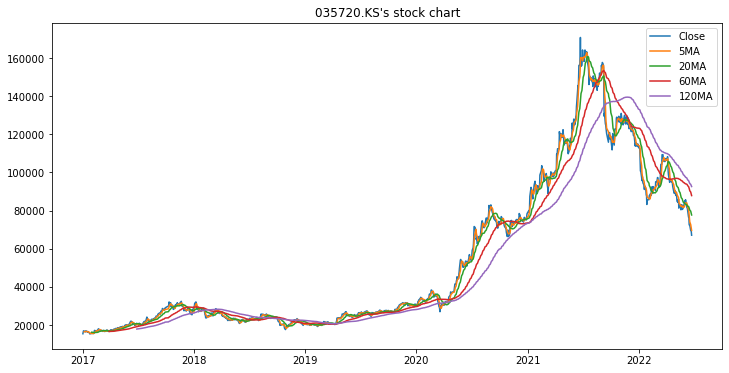

In [16]:
kakao_code = '035720.KS'
makeStockChart( code=kakao_code )

In [17]:
# 데이터 가져오기
datas = web.DataReader( kakao_code, 'yahoo', start, end)

# 컬럼 ds(YYYY-MM-DD), y(종가 : Close) 구성
# 해당 구저의 DateFrame만들기 위한 딕셔너리 선언

dic = {
    'ds' : datas.index,
    'y' : datas.Close
}

# ds 와 y를 컬럼으로 갖는 데이터 프레임 생성
df = pd.DataFrame( dic )

#인덱스 초기화(원본 까지 적용)
df.reset_index( inplace=True )

# 'ds' 컬럼과 중복되는 'Date' 컬럼 제거
del df['Date']

# 페이스북의 시계열 예측 모델에 사용한 데이터 준비
df.head(5)

,ds,y
0,2017-01-02,15452.805664
1,2017-01-03,16117.659180
2,2017-01-04,16983.982422
3,2017-01-05,16923.541016
4,2017-01-06,16863.101562


c:\Users\rjs74\pythonproject\anaconda3\envs\downgrade\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\rjs74\pythonproject\anaconda3\envs\downgrade\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\rjs74\pythonproject\anaconda3\envs\downgrade\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


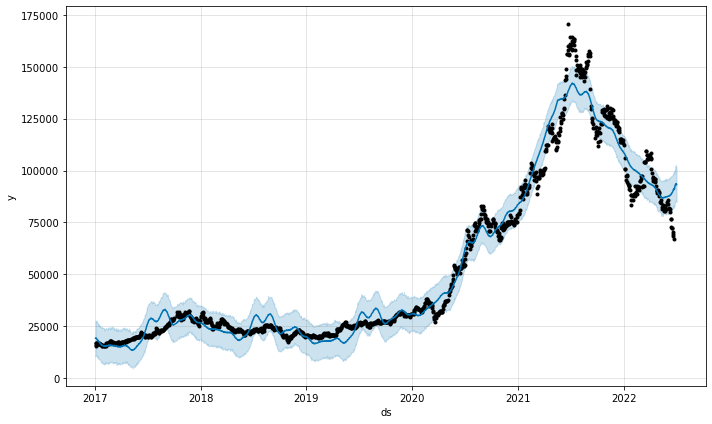

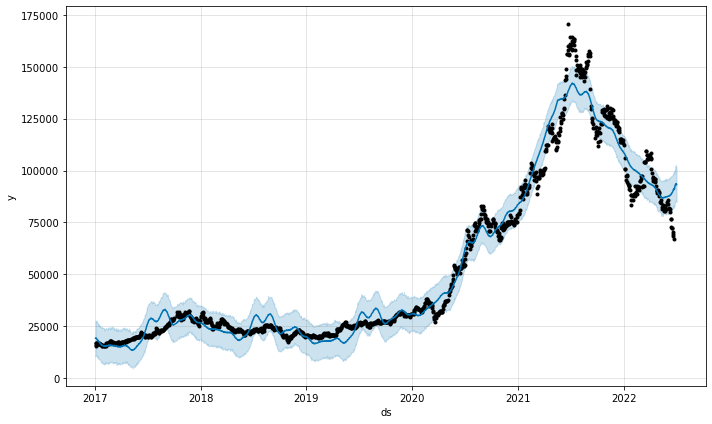

In [18]:
# prophet 모듈 세팅
from fbprophet import Prophet

# Day 단위로 데이터가 구성되어 있으므로, 일 단위 주기성 활성화
model = Prophet( daily_seasonality=True ) 

# 데이터 학습 시작 -> 기계학습
model.fit( df )

# 주가 예측 위한 날짜 데이터 세팅 -> 기존 데이터 + 향후 10일치 예측값
future = model.make_future_dataframe( periods=10 )

# 주가 예측
forecast = model.predict( future )

# forecast.columns ->
'''
  Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
''' 

# 필요한 컬럼만 보기
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11)

# 모델이 제공하는 시각화
model.plot(forecast)

c:\Users\rjs74\pythonproject\anaconda3\envs\downgrade\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\rjs74\pythonproject\anaconda3\envs\downgrade\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\rjs74\pythonproject\anaconda3\envs\downgrade\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


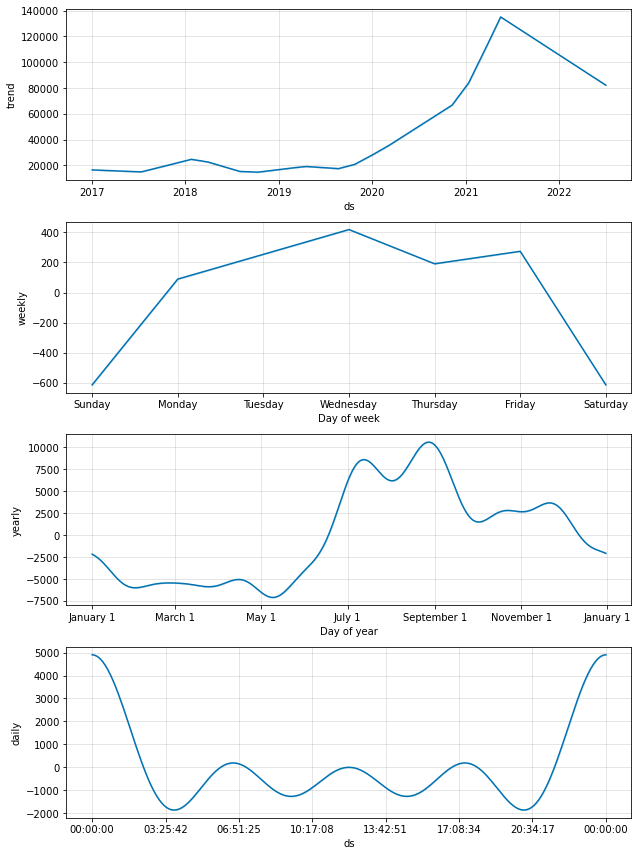

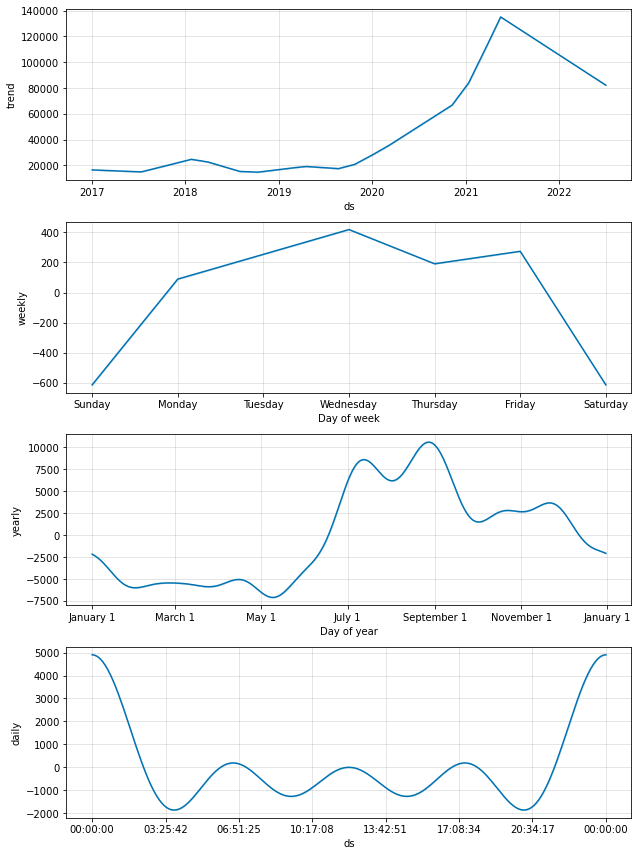

In [19]:
model.plot_components( forecast )